Switch to GPU

In [6]:
#Installs for NVIDIA GeForce RTX 3080
#pip install scikit-learn
#pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
#separately download cuda_12.3.1_546.12_windows & follow express install instructions

import torch

# Check if GPU is available
if torch.cuda.is_available():
    # Print the name of the GPU
    print(torch.cuda.get_device_name(0))
else:
    print("No GPU available, using CPU.")

NVIDIA GeForce RTX 3080


Dataset Class (https://doi.org/10.1021/acsomega.2c00640)

In [7]:
import pandas as pd
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence

class AminoAcidDataset(Dataset):
    def __init__(self, df, amino_acids):
        self.sequences = df['Sequence'].tolist() # Look for a sequence column that contains the peptide sequences
        self.classes = df['Class'].tolist() # Look for the column that has the class of interest (binary category)
        self.amino_acid_mapping = {acid: i for i, acid in enumerate(amino_acids)} # Generate a 0-n list of integers to map to AA-list fed into the class
    
    # Required function in the dataset class to get length of dataset
    def __len__(self):
        return len(self.sequences)
    
    # Required function in the dataset class to get values and labels
    # LSTM needs the data to be one-hot-encoded
    # Labels are binary class labels (0 to 1)
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.classes[idx]
        one_hot_encoding = self.sequence_to_one_hot(sequence)
        label_tensor = torch.tensor([1, 0] if label == 1 else [0, 1], dtype=torch.float32)
        return one_hot_encoding, label_tensor
    
    # This function is called on in the required getitem class to generate one-hot-encodings
    def sequence_to_one_hot(self, sequence):
        sequence = sequence.upper()
        one_hot_encoding = torch.zeros(len(sequence), len(self.amino_acid_mapping))
        for i, amino_acid in enumerate(sequence):
            if amino_acid in self.amino_acid_mapping:
                one_hot_encoding[i, self.amino_acid_mapping[amino_acid]] = 1
        return one_hot_encoding

# This function will be called on in the dataloader method below to pad variable sequence lengths
# nn.LSTM only considers the valid elements, ignoring the padded values, so the model will not train on padding
def collate_fn(batch):
    sequences, labels = zip(*batch)
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    return padded_sequences, torch.stack(labels)

LSTM Model

In [8]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

Train/Test/Split DataLoader

In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.optim as optim
import pandas as pd

# Prepare training and testing data
file_path = 'FILE.xlsx' # Path to raw data
df = pd.read_excel(file_path)
filtered_df_0 = df[df['Class'] == 0]
filtered_df_1 = df[df['Class'] == 1].sample(n=len(filtered_df_0), random_state=42)
filtered_df = pd.concat([filtered_df_0, filtered_df_1])
filtered_df = filtered_df.sample(frac=1, random_state=42).reset_index(drop=True)
amino_acids = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V'] # Amino acid one-hot-encoding order
dataset = AminoAcidDataset(filtered_df, amino_acids) # Call on the dataset class method defined earlier
split = train_test_split(dataset, test_size=0.1, random_state=42) # Scikit-learn train/test/split to generate training and testing data
training_set = split[0] # Sequence(x), Label(y) = training_set[n], and the outputs are tensors: (x): peptide length,21; (y): class label (0 or 1)
testing_set = split[1] # Sequence(x), Label(y) = testing_set[n], and the outputs are tensors: (x): peptide length,21; (y): class label (0 or 1)
batchsize = 64
train_dataloader = DataLoader(training_set, batch_size=batchsize, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(testing_set, batch_size=batchsize, shuffle=True, collate_fn=collate_fn)

# Initiate model inputs
input_size = 20  # Number of amino acids (including X)
num_classes = 2  # Binary classification: positive or negative
hidden_size = 100  # Choose an appropriate hidden size
model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001) # Set learning rate & L2 regularization
num_epochs = 50

Training loop

Epoch 1/50 => Train Loss: 0.6926, Train Accuracy: 0.5156, Test Loss: 0.6919, Test Accuracy: 0.3556
Epoch 2/50 => Train Loss: 0.6854, Train Accuracy: 0.5781, Test Loss: 0.6745, Test Accuracy: 0.6889
Epoch 3/50 => Train Loss: 0.6007, Train Accuracy: 0.7188, Test Loss: 0.5660, Test Accuracy: 0.7500
Epoch 4/50 => Train Loss: 0.5149, Train Accuracy: 0.7500, Test Loss: 0.5380, Test Accuracy: 0.7656
Epoch 5/50 => Train Loss: 0.4885, Train Accuracy: 0.7656, Test Loss: 0.5122, Test Accuracy: 0.7812
Epoch 6/50 => Train Loss: 0.4762, Train Accuracy: 0.7969, Test Loss: 0.5203, Test Accuracy: 0.7344
Epoch 7/50 => Train Loss: 0.4622, Train Accuracy: 0.7969, Test Loss: 0.5006, Test Accuracy: 0.7969
Epoch 8/50 => Train Loss: 0.4718, Train Accuracy: 0.7812, Test Loss: 0.5061, Test Accuracy: 0.7656
Epoch 9/50 => Train Loss: 0.4655, Train Accuracy: 0.7969, Test Loss: 0.4951, Test Accuracy: 0.7812
Epoch 10/50 => Train Loss: 0.4628, Train Accuracy: 0.7812, Test Loss: 0.4902, Test Accuracy: 0.8000
Epoch 11/

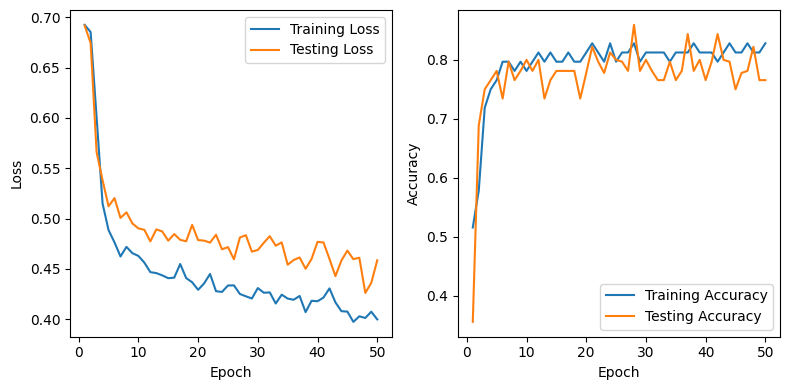

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# If cuda was set up correctly, you should be able to do this on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Move the model to the device

train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):
    model.train()
    totalTrainLoss = 0
    train_accuracy_batch = []
    
    for batch in train_dataloader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs).squeeze(dim=1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        totalTrainLoss += loss.item()
        predictions_train = (torch.sigmoid(outputs) > 0.5).float()
        correct_predictions = (labels == predictions_train).all(dim=1).sum().item()
        accuracy = correct_predictions / labels.size(0)
        train_accuracy_batch.append(accuracy)
        
    avg_train_loss = totalTrainLoss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    avg_train_accuracy = np.median(train_accuracy_batch)
    train_accuracy.append(avg_train_accuracy)
    
    model.eval()
    totalTestLoss = 0
    test_accuracy_batch = []
     
    for batch in test_dataloader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs).squeeze(dim=1)
        loss = criterion(outputs, labels)
        
        totalTestLoss += loss.item()
        predictions_test = (torch.sigmoid(outputs) > 0.5).float()
        correct_predictions = (labels == predictions_test).all(dim=1).sum().item()
        accuracy_test = correct_predictions / labels.size(0)
        test_accuracy_batch.append(accuracy_test)
        
    avg_test_loss = totalTestLoss / len(test_dataloader)
    test_losses.append(avg_test_loss) 
    avg_test_accuracy = np.median(test_accuracy_batch)
    test_accuracy.append(avg_test_accuracy)
    
    print(f"Epoch {epoch + 1}/{num_epochs} => "
          f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, "
          f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.4f}")

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot the training and testing losses
ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
ax1.plot(range(1, num_epochs + 1), test_losses, label='Testing Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot the training and testing accuracies
ax2.plot(range(1, num_epochs + 1), train_accuracy, label='Training Accuracy')
ax2.plot(range(1, num_epochs + 1), test_accuracy, label='Testing Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

Test Model

In [25]:
# Grab the inputs, ground truth, and predictions
for batch in test_dataloader:
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs).squeeze(dim=1)
    predictions_test = (torch.sigmoid(outputs) > 0.5).float()
    predictions = predictions_test.cpu().detach().numpy()
    ground_truth = labels.cpu().detach().numpy()

# Convert one-hot-encoded amino acids back into their original sequences
index_tensor = torch.argmax(inputs, dim=-1).cpu().numpy()
sequences = []
for row in index_tensor:
    sequence = ''.join([amino_acids[i] for i in row])
    sequences.append(sequence)

# See which peptides were misclassified
for i in range(len(sequences)):
    print(f'Ground Truth: {ground_truth[i]}')
    print(f'Prediction: {predictions[i]}')
    print(f'Sequence: {sequences[i]}')
    print('\n')

Ground Truth: [0. 1.]
Prediction: [1. 0.]
Sequence: KRPTHWNHHE


Ground Truth: [1. 0.]
Prediction: [1. 0.]
Sequence: TWHGMEWKSG


Ground Truth: [0. 1.]
Prediction: [0. 1.]
Sequence: AHSFEHEARE


Ground Truth: [1. 0.]
Prediction: [1. 0.]
Sequence: HEYGKMSEQW


Ground Truth: [0. 1.]
Prediction: [0. 1.]
Sequence: SRHHHHHERR


Ground Truth: [1. 0.]
Prediction: [1. 0.]
Sequence: KKTHEWWTQR


Ground Truth: [1. 0.]
Prediction: [1. 0.]
Sequence: WLSWRLQVAE


Ground Truth: [0. 1.]
Prediction: [1. 0.]
Sequence: NMEMWQVKKM


Ground Truth: [1. 0.]
Prediction: [1. 0.]
Sequence: EWWTERNWHQ


Ground Truth: [0. 1.]
Prediction: [1. 0.]
Sequence: WEMWWHWLSY


Ground Truth: [0. 1.]
Prediction: [1. 0.]
Sequence: EEESEYQEAG


Ground Truth: [1. 0.]
Prediction: [1. 0.]
Sequence: WSIHWTEEAS


Ground Truth: [0. 1.]
Prediction: [0. 1.]
Sequence: KQNMKTLVAW


Ground Truth: [0. 1.]
Prediction: [0. 1.]
Sequence: KMTGGVSHKR


Ground Truth: [0. 1.]
Prediction: [0. 1.]
Sequence: AKMTVRMKQK


Ground Truth: [1. 0.]
Pre